# Generic ALP realignment

In [5]:
%run observables.py
%run analysis_tools.py
%run generic_alp.py
%run util.py
import tqdm.notebook
import matplotlib as mpl

## Parameter space from paper

In [3]:
dilutions = load_pkl(dilutions_filename)
all_example_trajectories = load_pkl(example_trajectories_filename)
sim_data = [load_data("generic_alp", v) for v in [1,2,3]]

In [4]:
def make_paramspace_exploration_plot(data, interesting_points, interesting_solutions, dilution):
    m_a, Gamma_inf = data["m_a"], data["Gamma_inf"]
    H_inf = data["H_inf"][0]
    A = np.log10(np.abs(data["eta"][0,:,:,0,0] * dilution) / eta_B_observed)
    levels = list(find_level(np.log10(m_a), np.log10(Gamma_inf), A))

    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig_inv_trans = fig.transFigure.inverted()

    subfig_fig = []

    for nth_point, (i, j) in enumerate(itertools.product([0, 2], range(3))):        
        axs[i, j].remove()
        gridspec = axs[i, j].get_subplotspec().get_gridspec()
        subfig = fig.add_subfigure(gridspec[i, j])
        ax1, ax2 = subfig.subplots(2, 1)
        border = 0.15
        subfig.subplots_adjust(hspace=0, left=border, right=1 - border)
        dist = 0.05
        subfig_fig.append(fig_inv_trans.transform(
            subfig.transSubfigure.transform((0.5, 1 + dist) if i == 2 else (0.5, -dist))))

        conv_factor, ts, sources, rates, red_chem_pots = \
            interesting_solutions[nth_point]

        for k in range(transport_equation.N):
            ax1.loglog(ts, np.abs(red_chem_pots[k, :]), label=transport_equation.charge_names[k])
        ax1.loglog(ts, np.abs(transport_equation.calc_B_minus_L(red_chem_pots)), label="$B - L$", lw=3, color="black")
        if nth_point == 0:
            ax1.legend(ncol=3, framealpha=1)
        # ax1.set_xlabel(r"$t \cdot \Gamma_\mathrm{inf}$")
        ax1.set_ylabel(r"$|\mu_i / T|$")
        ax1.set_xlim(ts[0], ts[-1])
        ax1.set_xticks([],[])
        secax = ax1.secondary_xaxis("top", 
            functions=(lambda inf: inf / conv_factor, lambda ax: ax * conv_factor))
        secax.set_xlabel(r"$t \cdot m_a + m_a / \Gamma_\mathrm{inf}$")

        ax_twin = ax2.twinx()
        ax2.semilogx(ts, rates, color="tab:blue", label="rate")
        ax_twin.semilogx(ts, sources, color="tab:orange", label="source")
        ax2.set_xlabel(r"$t \cdot \Gamma_\mathrm{inf}$")
        ax2.set_ylabel(r"rate $- \sum_{\alpha i} \gamma_\alpha n^\alpha_i n_{B - L}^i$")
        ax_twin.set_ylabel(r"source $\dot{\theta} / T / 10^{-13}$")
        ax2.legend(loc=3, framealpha=1)
        ax_twin.legend(loc=4, framealpha=1)
        ax2.set_xlim(ts[0], ts[-1])

    for j in range(3):
        axs[1, j].remove()
    gridspec = axs[1, 0].get_subplotspec().get_gridspec()
    subfig = fig.add_subfigure(gridspec[1, :])
    ax = subfig.subplots()
    ax.set_xscale("log")
    ax.set_yscale("log")
    mappable = ax.contourf(m_a, Gamma_inf, A, levels=15)

    for xs, ys in levels:
        ax.plot(10**xs, 10**ys, "r", lw=3)

    ax.set_xlabel("$m_a$ / GeV")
    ax.set_ylabel(r"$\Gamma_\mathrm{inf}$ / GeV")
    ax.annotate(r"$a F \tilde{F}$", (0.9, 0.9), xycoords="axes fraction", backgroundcolor="white")
    subfig.colorbar(mappable, ax=ax,label=r"$\log_{10}(\eta_B / \eta_B^\mathrm{obs})$")

    interesting_points_marker_colors = []
    interesting_points_fig = []
    for p in interesting_points:
        l, = ax.plot(*p, "o")
        interesting_points_marker_colors.append(l.get_markerfacecolor())
        interesting_points_fig.append(fig_inv_trans.transform(ax.transData.transform(p)))

    for arrow_end, arrow_start, arrow_color in zip(interesting_points_fig, subfig_fig, 
                                                   interesting_points_marker_colors):
        ax.annotate("", xy=arrow_end, xytext=arrow_start, xycoords="figure fraction", 
                     textcoords="figure fraction", arrowprops=dict(color=arrow_color))

    #fig.suptitle(f"$f_a = {latex_exponential_notation(f_a, 2)}, H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)}$")

/tmp/ipykernel_1754417/39245113.py:75: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.annotate("", xy=arrow_end, xytext=arrow_start, xycoords="figure fraction",


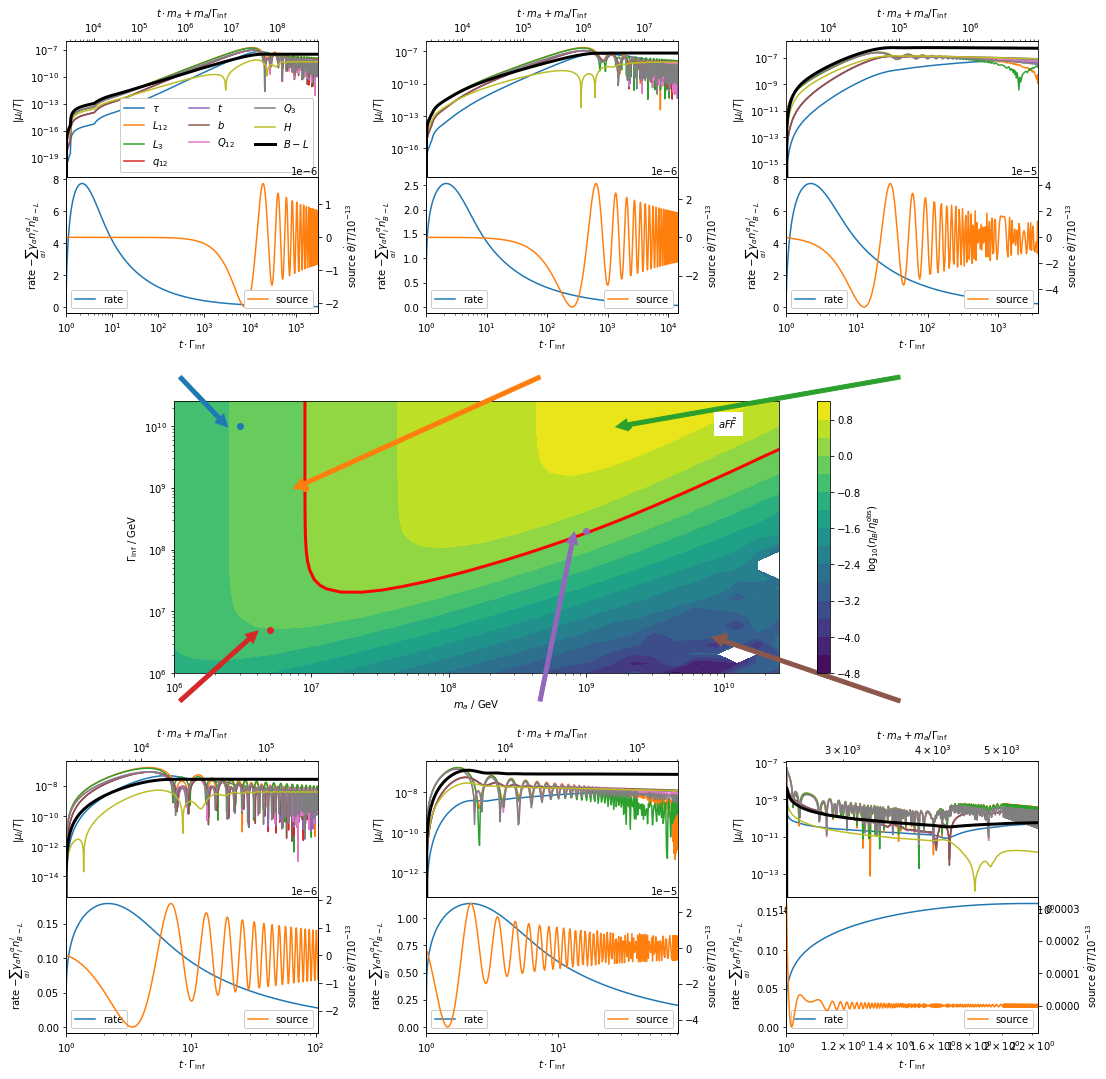

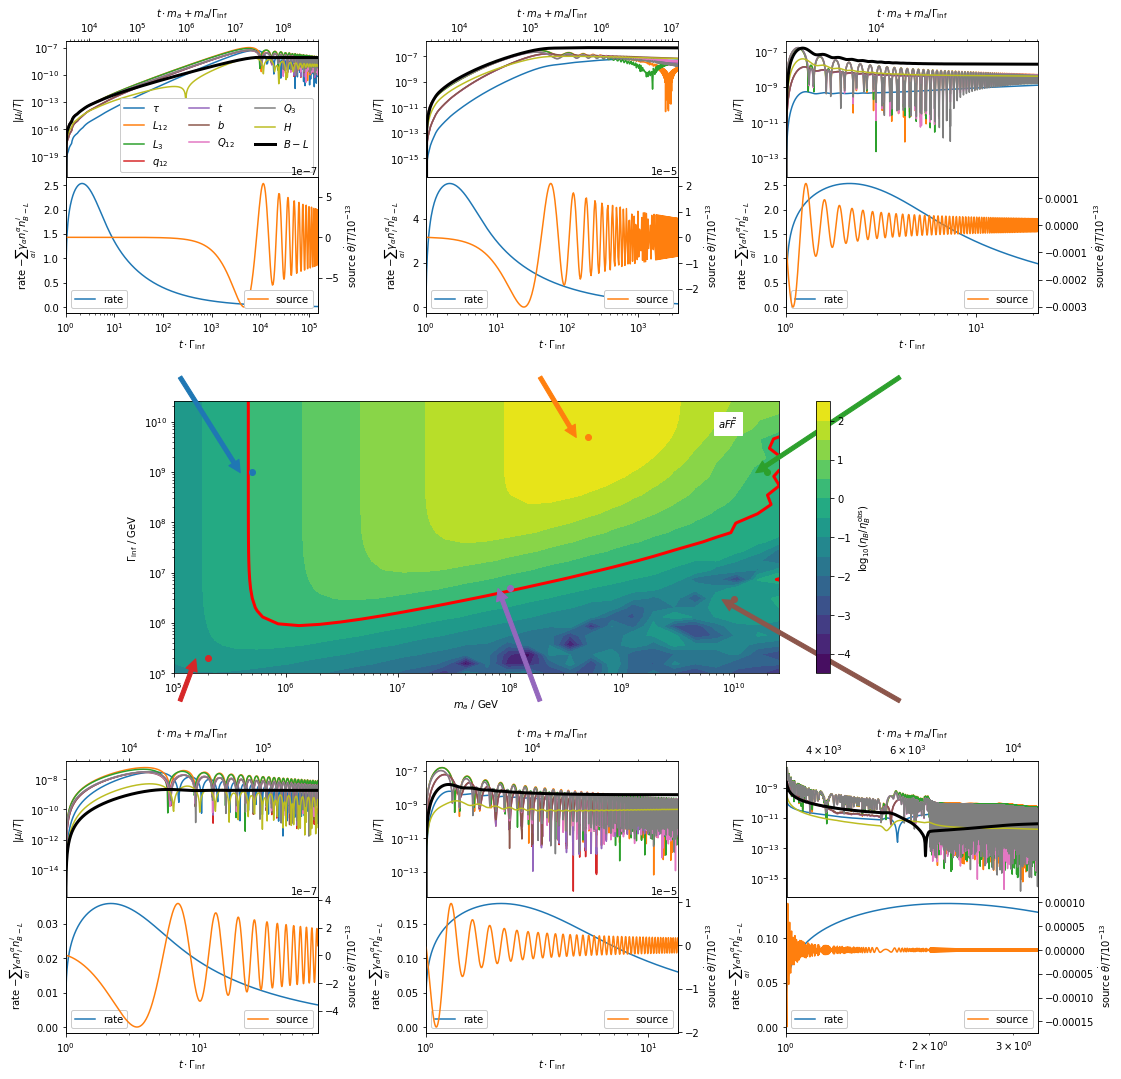

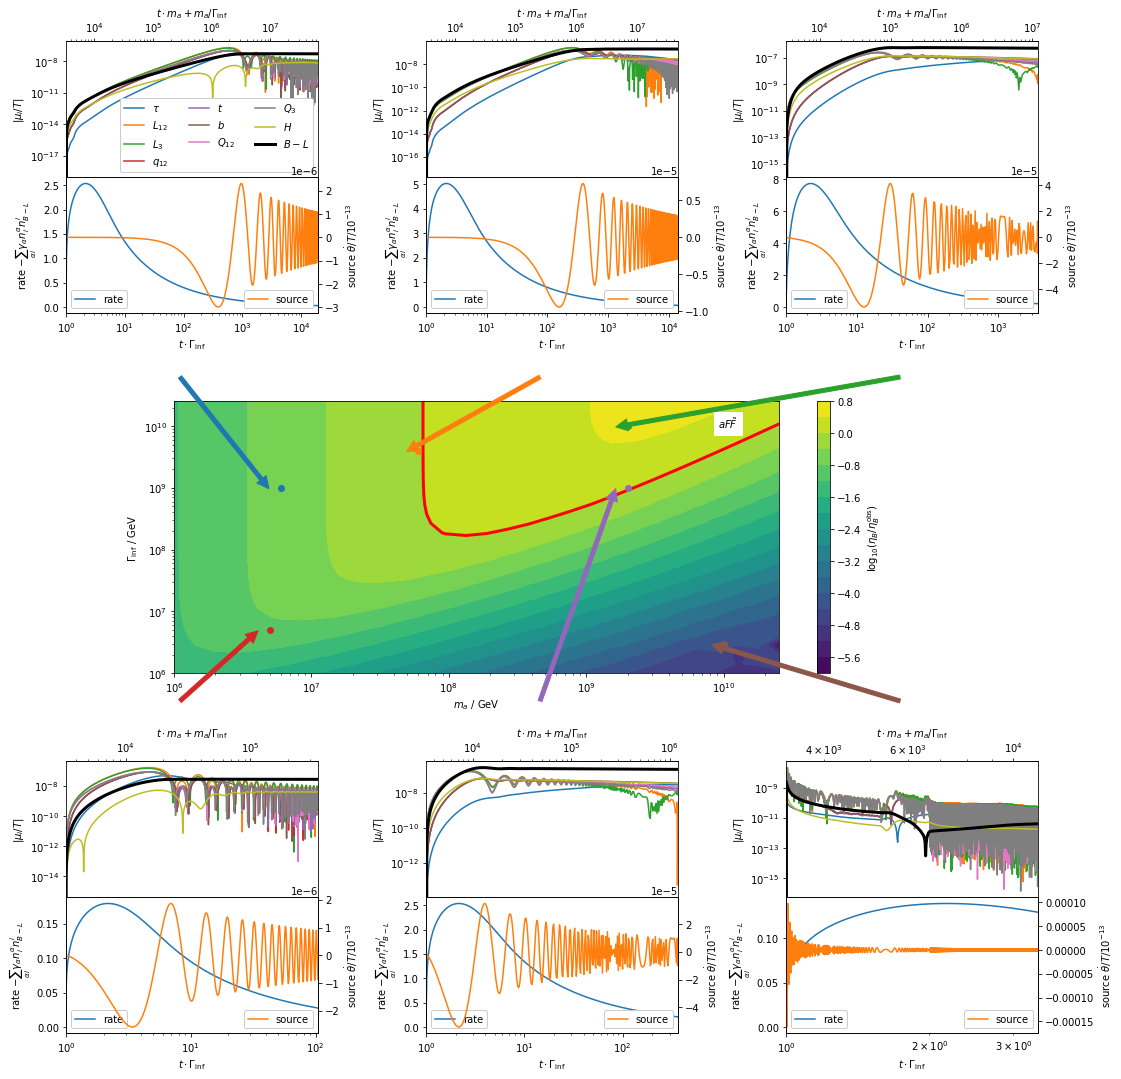

In [8]:
for dilution, example_trajectories, data, ps in zip(dilutions, all_example_trajectories, sim_data, all_points):
    make_paramspace_exploration_plot(data, ps, example_trajectories, dilution)

## Compare Couplings (Source Vectors)

In [17]:
plot_data = []
for d, data in zip(dilutions, sim_data):
    m_a, Gamma_inf = data["m_a"], data["Gamma_inf"]
    H_inf = data["H_inf"][0]
    eta = data["eta"][0,:,:,0,0] 
    A = np.log10(np.abs(eta * d / eta_B_observed))
    plot_data.append((m_a, Gamma_inf, A))
minval = min(np.nanmin(A) for _, _, A in plot_data)
maxval = max(np.nanmax(A) for _, _, A in plot_data)
m_a_min = min(x[0] for x, _, _ in plot_data)
m_a_max = max(x[-1] for x, _, _ in plot_data)

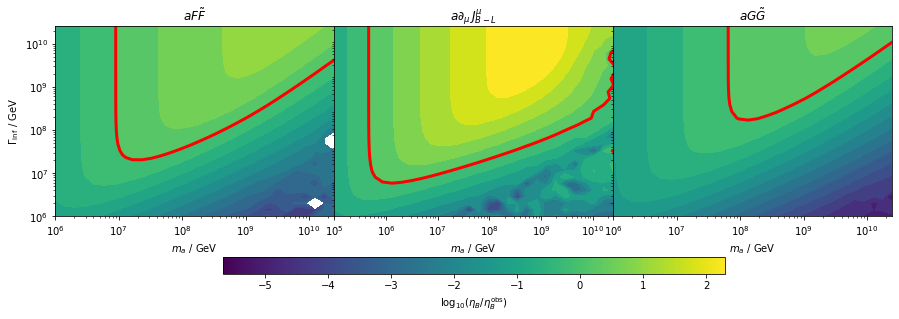

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.subplots_adjust(wspace=0)
norm = mpl.colors.Normalize(vmin=minval, vmax=maxval)
cmap = plt.cm.get_cmap("viridis")
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for i, (m_a, Gamma_inf, A) in enumerate(plot_data):
    levels = list(find_level(np.log10(m_a), np.log10(Gamma_inf), A))
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i != 0:
        axs[i].set_yticks([], [])
    else:
        axs[i].set_ylabel(r"$\Gamma_\mathrm{inf}$ / GeV")
    axs[i].contourf(m_a, Gamma_inf, A, levels=15, vmin=minval, vmax=maxval, cmap=cmap)
    for xs, ys in levels:
        axs[i].plot(10**xs, 10**ys, "r", lw=3)
    axs[i].set_title(transport_equation.source_vector_names[i])
    axs[i].set_xlabel("$m_a$ / GeV")
fig.colorbar(mappable=mappable, ax=axs, label=r"$\log_{10}(\eta_B / \eta_B^\mathrm{obs})$", 
             location="bottom", shrink=0.6, aspect=30)

## Correct curves as a function of $f_a$

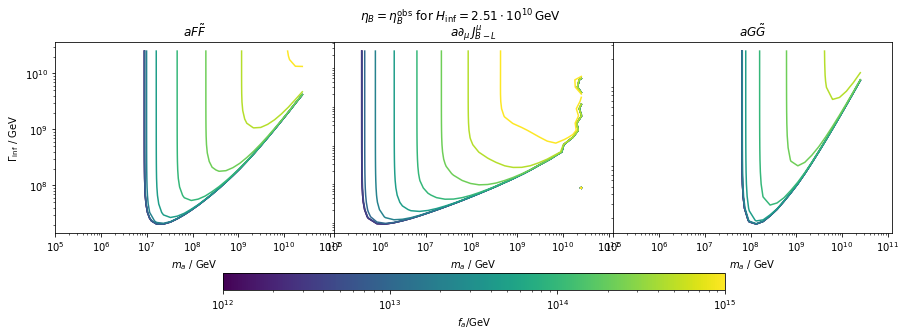

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(wspace=0)
cmap = plt.cm.get_cmap("viridis")
norm = mpl.colors.LogNorm(vmin=np.min(f_a_list), vmax=np.max(f_a_list))
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for i in range(3):
    correct_alp_curves_filename = os.path.join(datadir, f"generic_alp_correct_curves{i + 1}.pkl")
    with open(correct_alp_curves_filename, "rb") as fhandle:
        f_a_list, correct_asym_curves = pickle.load(fhandle)
    for f_a, curve in zip(f_a_list, correct_asym_curves):
        c = mappable.to_rgba(f_a)
        for xs, ys in curve:
            axs[i].loglog(xs, ys, color=c)
    if i == 0:
        axs[i].set_ylabel(r"$\Gamma_\mathrm{inf}$ / GeV")
    else:
        axs[i].set_yticks([], [])
    axs[i].set_xlabel("$m_a$ / GeV")
    axs[i].set_title(transport_equation.source_vector_names[i])
    axs[i].set_xlim(m_a_min, m_a_max * 5)
plt.suptitle(f"$\\eta_B = \\eta_B^\\mathrm{{obs}}$ for $H_\\mathrm{{inf}} = {latex_exponential_notation(H_inf, 2)} \\, \\mathrm{{GeV}}$")
fig.colorbar(mappable=mappable, ax=axs, label=r"$f_a / \mathrm{GeV}$", location="bottom", shrink=0.6, aspect=30)